# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [6]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

In [7]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Учитель",
    'area': 1,
    'page': 23,
    'per_page': 10
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [8]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [9]:
jobs = [
    'Электромеханик',
    'Питон разработчик',
    'Охраник',
    'Репетитор',
    'Кассир'
]

params = {
    'text': "",
    'area': 1,
    'page': 0,
    'per_page': 10
}

all_vacancies = {}

for job in jobs:
    all_vacancies[job] = []
    params['text'] = job
    params['page'] = 0
    data = requests.get(URL, params).json()
    pages = data['pages']
    sleep(0.5)
    while params['page'] < pages:
        all_vacancies[job].extend(data['items'])
        params['page'] += 1
        data = requests.get(URL, params).json()
        if not 'pages' in data:
            sleep(5)
            data = requests.get(URL, params).json()
        sleep(0.2)



        




(1 балл) Посчитайте сколько всего найдено вакансий:

In [27]:
for key in all_vacancies:
    print(key, len(all_vacancies[key]))

Электромеханик 302
Питон разработчик 6
Охраник 2
Репетитор 2000
Кассир 2000


In [11]:
total_vacancies = len(all_vacancies[jobs[0]]) + len(all_vacancies[jobs[1]]) + len(all_vacancies[jobs[2]]) + len(all_vacancies[jobs[3]]) + len(all_vacancies[jobs[4]])
total_vacancies

4310

(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [12]:
class Company:
        def __init__(self, company_name, longitude, latitude):
                self.company_name = company_name
                self.longitude = longitude
                self.latitude = latitude

(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [14]:
employers = {}

for vacancy in all_vacancies.values():
    for one_vacancy in vacancy:
        if not 'employer' in one_vacancy:
            continue
 
        company = one_vacancy['employer']
        if not 'id' in company:
            continue
        company_id = company['id']

        address = one_vacancy["address"]

        if address is None:
            continue
        company_obj = Company(company_name=company['name'],
                              longitude=address['lng'],
                              latitude=address['lat'])
        employers[company_id] = company_obj


len(employers)


1608

(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [15]:
total_company_with_pos = 0
for company in employers.values():
    total_company_with_pos += 1 if company.longitude is not None and company.latitude is not None else 0
total_company_with_pos

1518

(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

Будем рассматривать МКАД как прямоугольник:

In [16]:

mkad_borders_lng_min = 37.368047 # съезд 59
mkad_borders_lng_max = 37.840983 # съезд 13
mkad_borders_lat_min = 55.572044 # съезд 81
mkad_borders_lat_max = 55.908490 # съезд 29

company_near_mkad = []

for company in employers.values():
    if company.longitude is None or company.latitude is  None:
        continue
    
    if mkad_borders_lng_min < company.longitude < mkad_borders_lng_max and mkad_borders_lat_min < company.latitude < mkad_borders_lat_max:
        company_near_mkad.append(company)



(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

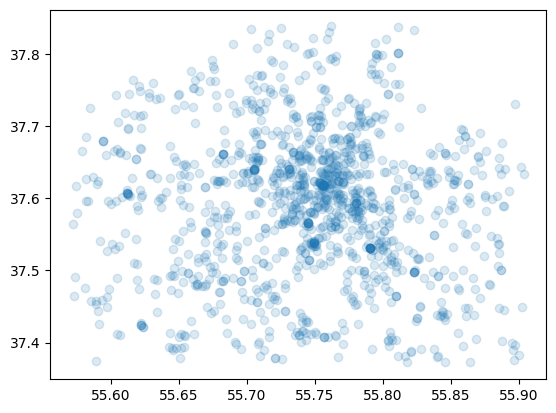

In [17]:
lngs = []
lats = []

for company in company_near_mkad:
    lngs.append(company.longitude)
    lats.append(company.latitude)

plt.scatter(x = lats, y = lngs, alpha = 0.16)

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве):

In [22]:
import plotly.express as px

data_frame = pd.DataFrame(columns = ["lat", "lng"])

moscow_center_lat = 55.753600
moscow_center_lng = 37.621184

for i in range(len(lats)):
    data_frame.loc[i] = [lats[i], lngs[i]]


fig = px.scatter_mapbox(data_frame, 
                        lat="lat", lon="lng", 
                        hover_name="lat", 
                        color_discrete_sequence=["fuchsia"], 
                        zoom=10, 
                        center={'lon': moscow_center_lng, 'lat':moscow_center_lat},
                        height=700)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

По этим данным мы можем сказать, что в центре Москвы есть большой спрос на услуги, которые мы искали. Из этого можно сделать вывод, что у жителей центра более высокая покупательная способность, чем у жителей за МКАДом. В большинстве своём, основная часть профессий за МКАДом, скорее всего, связана с работой кассиров (поскольку людям все-таки нужно ходить в магазины и покупать продукты), а также, возможно, репетиторством (поскольку это также одна из распространённых профессий в общем сравнении с другими).

Ваши выводы здесь :)

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [28]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

/bin/bash: строка 1: gdown: команда не найдена


Создадим DataFrame:

In [29]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv")
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,...,8.66,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,...,5.71,TK,XTK,unknown,NaN,Green,unknown,NaN,Fancy Light,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,...,10.20,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


(0.5 балла) Выведете первые 5 строк датасета:

In [36]:
diamonds.head(5)

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [32]:
len(diamonds)

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [50]:
key_max = max_index = diamonds['total_sales_price'].idxmax()
max = diamonds['total_sales_price'].loc[key_max]

key_min = max_index = diamonds['total_sales_price'].idxmin()
min = diamonds['total_sales_price'].loc[key_min]
print(f'{key_max} - {max}')
print(f'{key_min} - {max}')



219702 - 1449881
0 - 1449881


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [59]:
diamonds[diamonds.isin(['None', 'unknown'])].count().sum()

1746027

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [65]:
boolean = diamonds.isin(['unknown', 'None'])
boolean = boolean.loc[:, boolean.sum() > 0]
boolean.columns.values

array(['color', 'cut_quality', 'eye_clean', 'culet_size',
       'culet_condition', 'girdle_min', 'girdle_max', 'fluor_color',
       'fluor_intensity', 'fancy_color_dominant_color',
       'fancy_color_secondary_color', 'fancy_color_overtone',
       'fancy_color_intensity'], dtype=object)

В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [ ]:
# your code here

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [ ]:
# your code here

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [ ]:
# your code here

(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [ ]:
# your code here

(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [ ]:
# your code here

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [ ]:
# your code here

(0.5 балла) А теперь с индексами, кратными 6:

In [ ]:
# your code here

(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [ ]:
# your code here

>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [ ]:
# your code here

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

In [ ]:
# your code here

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

In [ ]:
# your code here

(2 балла) Постройте график `вес бриллианта - стоимость`:

In [ ]:
# your code here

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

In [ ]:
# your code here

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

Ваши выводы здесь :)

## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно:
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк:

In [ ]:
# your code here

(1 балл) Перемешайте строки в датафрейме случайным образом:

In [ ]:
# your code here

(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [ ]:
# your code here

(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`:

In [ ]:
# your code here

(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [ ]:
# your code here

(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

In [ ]:
# your code here

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

In [ ]:
# your code here

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [ ]:
# your code here

(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [ ]:
# your code here

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [ ]:
# your code here

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [ ]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [ ]:
# your code here

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [ ]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)